# Comparing the Performance of Machine Learning Methods for Predicting Material Properties
This notebook makes some tests to assess the performance of different strategies for predicting the properties of materials with machine learning. 
For the regression strategies, we use linear regression, Decision Tree, Rotation ForestRegressor and Random Subspace. For the classification strategies, we use Decision Tree, Rotation ForestRegressor and Random Subspace.
The data sets used in this notebook is boltztrap_mp, citrine_thermal_conductivity and glass_ternary_landolt.

In [115]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, BaggingClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, cross_val_predict, ShuffleSplit
from sklearn.base import BaseEstimator, clone
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from matminer.data_retrieval import retrieve_MDF
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matminer.datasets import load_dataset
from RotationTree import RotationForestRegressor, RotationForestClassifier
import numpy as np
import pandas as pd
import math
import warnings

warnings.filterwarnings("ignore")
class ModelTuner:
    '''Determines the best model parameters given a certain dataset'''

    def __init__(self, model, param_list):
        ''' Args:
            model (BaseEstimator): Model to be trained
            param_list ([(str, list)]): List of parameters to be tuned and the ranges of acceptable values
        '''
        self.model = model
        self.param_list = param_list
        self.model.get_params()

    def tune(self, X, y):
        '''Given a dataset, return a tuned model
        Args:
        X (ndarray): List of features for each entry
        y (ndarray): List of labels for each entry
        Returns:
        - (BaseEstimator): Model with the tuned hyperparameters
        - (dict): Value of the parameters that were tuned for the best estimator'''
        # Clone model template
        model = clone(self.model)
        # Loop over all parameters to tune
        best_params = {}
        for param_name, param_values in self.param_list:
            # Create the grid search for tuning that parameter
            gs = GridSearchCV(model, {param_name: param_values}, cv=ShuffleSplit(n_splits=1, test_size=0.1))
            # Run the tuning
            gs.fit(X, y)
            # Get the best estimator
            model = gs.best_estimator_
            # Store the tuned values
            best_params.update(gs.best_params_)

        return model, best_params


In [ ]:
def rresult(name,x,y,model):
    '''calculate the MSE of a regression model and make a plot for the measured values and predicted values
    
        Args:
        name (str): Property to be predicted
        x (ndarray): List of features for each entry
        y (ndarray): List of labels for each entry
        model (BaseEstimator): model has been tuned which has the best params
        
        Returns:
        - (float): value fo the MSE
    
    '''
    # calculate the MSE with 10-fold cross validation
    crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
    cv_prediction = cross_val_predict(model, x, y, cv=crossvalidation)
    # get the MSE
    e = getattr(metrics,'mean_absolute_error')(y, cv_prediction)
    # make plots
    fig, ax = plt.subplots()
    ax.scatter(y, cv_prediction, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel(name + '_' + 'Measured')
    ax.set_ylabel(name + '-' + 'Predicted')
    plt.show()
    print(name,e)
    return e

In [116]:
 def cresult(name,x,y,model):
    
    '''calculate the accuracy of a classification model
    
        Args:
        name (str): Property to be predicted
        x (ndarray): List of features for each entry
        y (ndarray): List of labels for each entry
        model (BaseEstimator): model has been tuned which has the best params
        
        Returns:
        - (float): value of the accuracy
    
    '''
    # calculate the MSE with 10-fold cross validation
    crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = cross_val_score(model, x, y, cv=crossvalidation)
    # get the MSE
    mse_scores = [abs(s) for s in scores]
    e =  np.mean(mse_scores)
    print(name,e)
    return e

In [124]:
def test(df,prediction,attribute,regression,preprocess,model_tuner,recordfile,dataname):
    '''do some tests with different datasets and different machine learning methods
    
        Args:
        df (dataframe): Dataset to be trained
        prediction (str): Property to be predicted
        attribute (str): Features to be trained
        regression (bool): Whether or not to figure a regression problem
        preprocess (bool): Whether or not to do preprocess on the values of the predicted property
        model_tuner ([ModelTuner]): Model to be trained
        recordfile (list): List of str contains the name of record files
        dataname (str): The name of the dataset

    '''
    #get the data we need
    data = df[[prediction, attribute]]
    #rename the columns
    data = data.rename(columns={prediction:prediction,  attribute:'composition'})
    data = StrToComposition(target_col_id='composition_obj').featurize_dataframe(data, 'composition')
    #remove the entry of which the value of property is None
    data = data[data[prediction]!='None']
    for k in [prediction]:
        data[k] = pd.to_numeric(data[k])

    original_count = len(data)
    #Remove entries with NaN or infinite property
    data = data[~ data[prediction].isnull()]
    print('Removed %d/%d entries'%(original_count - len(data), original_count))

    #Get only the groundstate and each composition
    original_count = len(data)
    data['composition'] = data['composition_obj'].apply(lambda x: x.reduced_formula)
    data.sort_values(prediction, ascending=True, inplace=True)
    data.drop_duplicates('composition', keep='first', inplace=True)
    print('Removed %d/%d entries'%(original_count - len(data), original_count))
    
    #convert the raw materials data into the required input for an ML model: a finite list of quantitative attributes. 
    feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                              cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
    feature_labels = feature_calculators.feature_labels()

    #Compute the features
    data = feature_calculators.featurize_dataframe(data, col_id='composition_obj')

    print('Generated %d features'%len(feature_labels))
    print('Training set size:', 'x'.join([str(x) for x in data[feature_labels].shape]))

    original_count = len(data)
    #Remove entries with NaN or infinite features
    data = data[~ data[feature_labels].isnull().any(axis=1)]
    print('Removed %d/%d entries'%(original_count - len(data), original_count))
    #if the value of property need preprocessing use log() to transform the original values 
    if preprocess:
        data.loc[:,prediction] =  np.log(df.loc[:,prediction]-2*min(df.loc[:,prediction])) 
    #Remove entries with NaN or infinite property
    data = data[~ data[prediction].isnull()]
    print('Removed %d/%d entries'%(original_count - len(data), original_count))
    #if a regression problem we need to do a linear regression
    if regression == True:
        rresult(prediction,data[feature_labels], data[prediction],LinearRegression())
    #train different models
    for i in range(len(model_tuner)): 
        model, best_params = model_tuner[i].tune(data[feature_labels],data[prediction])
        if regression == True:
            score = rresult(prediction,data[feature_labels], data[prediction],model)
            best_params['MSE'] = score
        else:
            score = cresult(prediction,data[feature_labels], data[prediction],model)
            best_params['Accuracy'] = score
        #save the best params for each model to the disk
        (pd.DataFrame(best_params,index = [dataname+'_'+prediction] )).to_csv(recordfile[i],mode='a')

In [118]:
#calculate the number of features for each subset for the rotation forest
features = []
for i in range(14,145):
    features.append(int(145/i))
features = list(set(features))
#list contains the regression models to be trained
rmodel = [DecisionTreeRegressor(),RotationForestRegressor(),BaggingRegressor(DecisionTreeRegressor())]
#list contains the classification models to be trained
cmodel = [DecisionTreeClassifier(),RotationForestClassifier(),BaggingClassifier(DecisionTreeClassifier())]
#list contains the params to be tuned for each model
params = [[('max_features',range(5,15)),('max_depth',range(10,100,10))],[('n_features_per_subset',features),('max_features',range(10,15))],[('max_features',[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]),('n_estimators',range(1,10))]]
#list contains the file name for recording the best params for each models
recordfile = ['DecisionTreeRegressor.csv','RotationForestRegressor.csv','RandomSubspace.csv']
rmodeltuner = []
cmodeltuner = []
for i in range(len(params)):
    rmodeltuner.append(ModelTuner(rmodel[i],params[i]))
    cmodeltuner.append(ModelTuner(cmodel[i],params[i]))

In [130]:
#dataset bolztrap
df = load_dataset('boltztrap_mp')


Removed 0/8924 entries
Removed 1544/8924 entries



Generated 145 features
Training set size: 7380x145
Removed 1/7380 entries
Removed 1/7380 entries


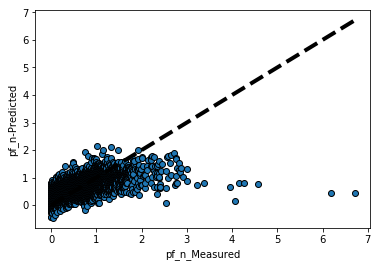

pf_n 0.24577598261879754


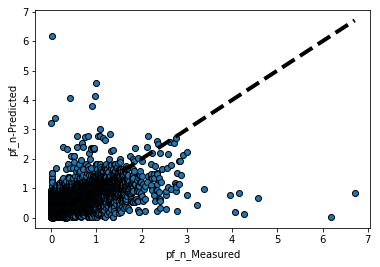

pf_n 0.2627830281810841


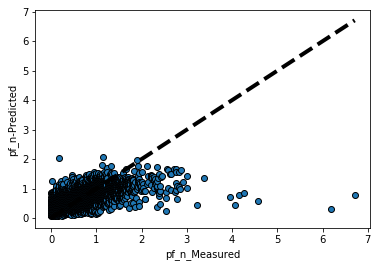

pf_n 0.2307509459593157


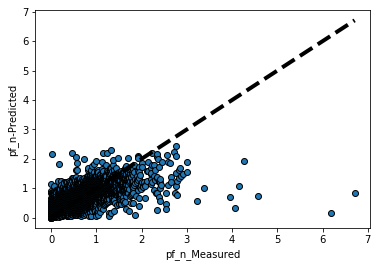

pf_n 0.20986852797740885



Removed 0/8924 entries
Removed 1544/8924 entries



Generated 145 features
Training set size: 7380x145
Removed 1/7380 entries
Removed 1/7380 entries


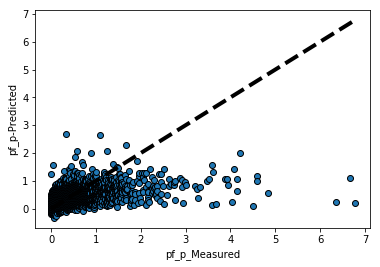

pf_p 0.20528405469514774


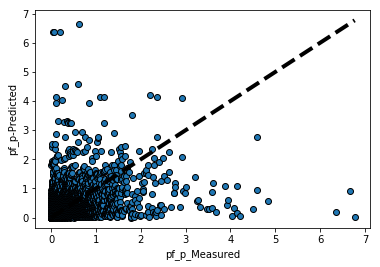

pf_p 0.23913180746532955


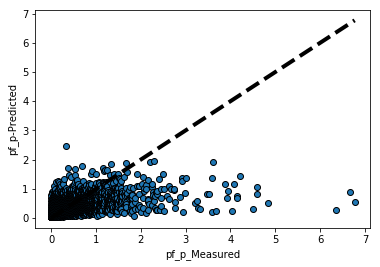

pf_p 0.19350693764236773


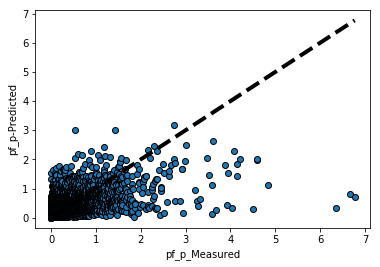

pf_p 0.19574828242726316


In [131]:
test(df,'pf_n','formula',True,False,rmodeltuner,recordfile,'boltztrap_mp')
test(df,'pf_p','formula',True,False,rmodeltuner,recordfile,'boltztrap_mp')
test(df,'s_n','formula',True,True,rmodeltuner,recordfile,'boltztrap_mp')
test(df,'s_p','formula',True,True,rmodeltuner,recordfile,'boltztrap_mp')
test(df,'m_n','formula',True,True,rmodeltuner,recordfile,'boltztrap_mp')
test(df,'m_p','formula',True,True,rmodeltuner,recordfile,'boltztrap_mp')

In [126]:
#dataset citrine_thermal_conductivity
df = load_dataset('citrine_thermal_conductivity')
df = df[(df['k_condition'].isin([300, 'room temperature', 'Room temperature', '298']))]


Removed 0/83 entries
Removed 36/83 entries



Generated 145 features
Training set size: 47x145
Removed 0/47 entries
Removed 1/47 entries


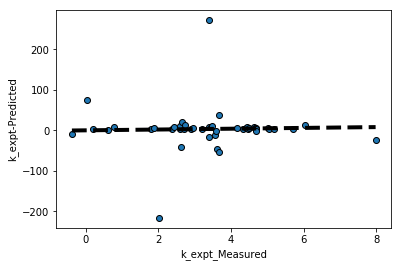

k_expt 20.512034473837513


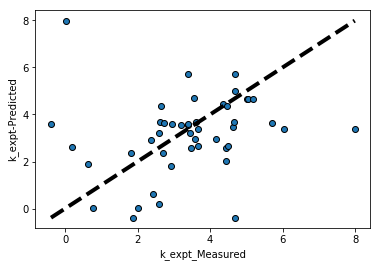

k_expt 1.4404782229008664


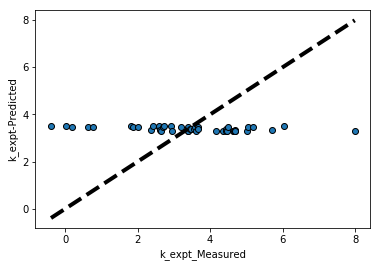

k_expt 1.2663538341254992


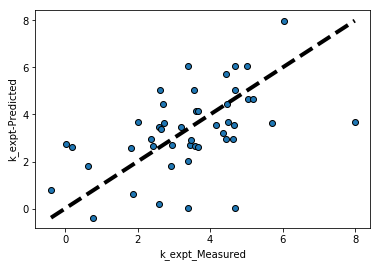

k_expt 1.3426339326753818


In [127]:
test(df,'k_expt','formula',True,True,rmodeltuner,recordfile,'citrine_thermal_conductivity')

In [128]:
#dataset glass_ternary_landolt
df = load_dataset('glass_ternary_landolt')
df=df[(df['processing'].isin(['meltspin']))]

In [129]:
test(df,'gfa','formula',False,False,cmodeltuner,recordfile,'glass_ternary_landolt')


Removed 0/6780 entries
Removed 1467/6780 entries



Generated 145 features
Training set size: 5313x145
Removed 0/5313 entries
Removed 0/5313 entries
gfa 0.8535760304716593
gfa 0.8891465953018137
gfa 0.8770977585205951
